In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from torchvision import transforms
import torchvision
import numpy as np
from resnet import ResNet, Bottleneck

class Trainer:
    def __init__(self, name, model, criterion, optimizer, device):
        """
        Initializes the Trainer.

        Args:
            model (nn.Module): The PyTorch model to train.
            criterion (nn.Module): The loss function.
            optimizer (torch.optim.Optimizer): The optimizer.
            device (torch.device): The device to train on (e.g., 'cuda' or 'cpu').
        """
        self.name = name
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train_epoch(self, dataloader):
        """
        Trains the model for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the training set.

        Returns:
            float: The average training loss for the epoch.
        """
        self.model.train()
        total_loss = 0.0
        num_batches = len(dataloader)

        for inputs, labels in dataloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss

    def validate_epoch(self, dataloader):
        """
        Evaluates the model on the validation set for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the validation set.

        Returns:
            float: The average validation loss for the epoch.
            float: The average validation accuracy for the epoch.
        """
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        num_batches = len(dataloader)

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        avg_loss = total_loss / num_batches
        accuracy = correct_predictions / total_samples
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        return avg_loss, accuracy

    def train(self, train_dataloader, val_dataloader, num_epochs):
        """
        Trains the model for a specified number of epochs and validates it, recording latency and throughput.

        Args:
            train_dataloader (DataLoader): The DataLoader for the training set.
            val_dataloader (DataLoader): The DataLoader for the validation set.
            num_epochs (int): The number of training epochs.
        """
        print(f"Training on {self.device}")
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(train_dataloader)
            val_loss, val_acc = self.validate_epoch(val_dataloader)
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

    def plot_losses_accuracies(self):
        """
        Plots the training loss, validation loss, and validation accuracy against the number of epochs.
        """
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure()
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(self.name + ' Training and Validation Loss')
        plt.legend()
        plt.show()

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=trans)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)

@torch.no_grad()
def measure_inference_time_with_warmup(model, data_loader, warmup_steps=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    # Warm-up
    for i, (inputs, _) in enumerate(data_loader):
        inputs = inputs.to(device)
        _ = model(inputs)
        if i >= warmup_steps - 1:
            break

    total_inference_time = 0
    num_samples = 0
    start_time = time.time() # Start timer after warm-up

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        _ = model(inputs)
        num_samples += inputs.size(0)

    end_time = time.time()
    total_inference_time = end_time - start_time
    throughput = num_samples / total_inference_time
    avg_latency_per_sample = total_inference_time / num_samples
    print(f"Average Latency per Sample (with warm-up): {avg_latency_per_sample * 1000:.2f} ms")
    print(f"Throughput (with warm-up): {throughput:.2f} samples/second")
    return avg_latency_per_sample, throughput

def fit_one(name,model,epochs,train_dataloader,val_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = Trainer(name = name,model = model,criterion = nn.CrossEntropyLoss(),optimizer= optim.SGD(model.parameters(),weight_decay=0.0001,momentum=0.9),device=device)
    trainer.train(train_dataloader, val_dataloader, epochs)
    trainer.plot_losses_accuracies()
    max_acc = np.max(trainer.val_accuracies)
    avg_latency, throughput = measure_inference_time_with_warmup(model, val_dataloader)
    return avg_latency,max_acc

Training on cuda
Epoch [1/20], Train Loss: 1.9373, Val Loss: 1.7135, Val Acc: 0.3808
Epoch [2/20], Train Loss: 1.5690, Val Loss: 1.4928, Val Acc: 0.4493
Epoch [3/20], Train Loss: 1.4038, Val Loss: 1.4059, Val Acc: 0.4859
Epoch [4/20], Train Loss: 1.2831, Val Loss: 1.3677, Val Acc: 0.5023
Epoch [5/20], Train Loss: 1.1824, Val Loss: 1.3210, Val Acc: 0.5267
Epoch [6/20], Train Loss: 1.0927, Val Loss: 1.3144, Val Acc: 0.5346
Epoch [7/20], Train Loss: 0.9981, Val Loss: 1.2622, Val Acc: 0.5501
Epoch [8/20], Train Loss: 0.9176, Val Loss: 1.2412, Val Acc: 0.5579
Epoch [9/20], Train Loss: 0.8280, Val Loss: 1.2334, Val Acc: 0.5725
Epoch [10/20], Train Loss: 0.7402, Val Loss: 1.2401, Val Acc: 0.5721
Epoch [11/20], Train Loss: 0.6582, Val Loss: 1.2836, Val Acc: 0.5683
Epoch [12/20], Train Loss: 0.5747, Val Loss: 1.2753, Val Acc: 0.5781
Epoch [13/20], Train Loss: 0.4946, Val Loss: 1.3276, Val Acc: 0.5744
Epoch [14/20], Train Loss: 0.4150, Val Loss: 1.4140, Val Acc: 0.5679
Epoch [15/20], Train Loss:

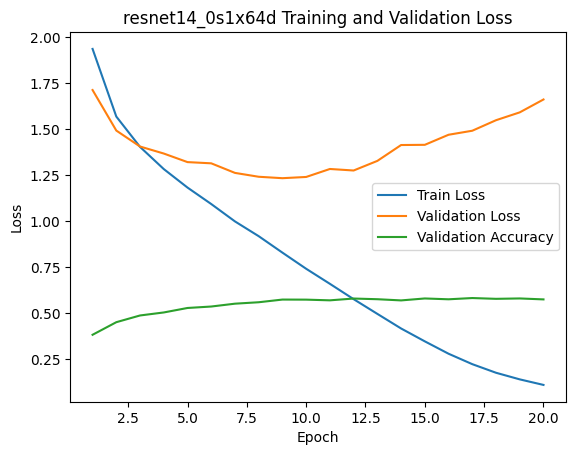

Average Latency per Sample (with warm-up): 0.12 ms
Throughput (with warm-up): 8177.58 samples/second
Training on cuda
Epoch [1/20], Train Loss: 1.7072, Val Loss: 1.4769, Val Acc: 0.4681
Epoch [2/20], Train Loss: 1.3645, Val Loss: 1.3313, Val Acc: 0.5205
Epoch [3/20], Train Loss: 1.2147, Val Loss: 1.3668, Val Acc: 0.5100
Epoch [4/20], Train Loss: 1.1031, Val Loss: 1.2229, Val Acc: 0.5636
Epoch [5/20], Train Loss: 1.0018, Val Loss: 1.3118, Val Acc: 0.5425
Epoch [6/20], Train Loss: 0.9139, Val Loss: 1.1361, Val Acc: 0.5965
Epoch [7/20], Train Loss: 0.8299, Val Loss: 1.1807, Val Acc: 0.5804
Epoch [8/20], Train Loss: 0.7452, Val Loss: 1.2031, Val Acc: 0.5900
Epoch [9/20], Train Loss: 0.6722, Val Loss: 1.1579, Val Acc: 0.6122
Epoch [10/20], Train Loss: 0.5931, Val Loss: 1.2001, Val Acc: 0.6094
Epoch [11/20], Train Loss: 0.5189, Val Loss: 1.2298, Val Acc: 0.6104
Epoch [12/20], Train Loss: 0.4435, Val Loss: 1.2202, Val Acc: 0.6123
Epoch [13/20], Train Loss: 0.3781, Val Loss: 1.2943, Val Acc: 0

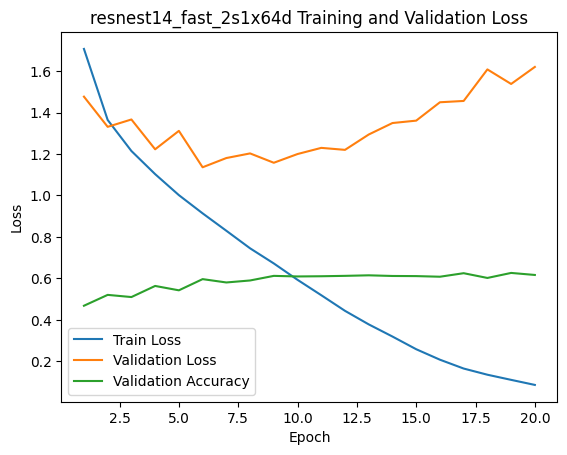

Average Latency per Sample (with warm-up): 0.15 ms
Throughput (with warm-up): 6471.93 samples/second
[('resnet14_0s1x64d', 0.0001222855806350708, np.float64(0.5808)), ('resnest14_fast_2s1x64d', 0.00015451345443725587, np.float64(0.6264))]


In [ ]:
model_dict = {}
result_list = []
model_dict['resnet14_0s1x64d'] = ResNet(Bottleneck, [1, 1, 1, 1],num_classes=10,final_drop=0.2,radix=0)
model_dict['resnest14_fast_2s1x64d'] = ResNet(Bottleneck, [1, 1, 1, 1],num_classes=10,final_drop=0.2,radix=2, groups=1, bottleneck_width=64,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=True)
for name,model in model_dict.items():
    avg_latency,max_acc = fit_one(name,model,20,train_dataloader,val_dataloader)
    result_list.append((name,avg_latency,max_acc))
print(result_list)